#### Model Testing

In [ ]:
import numpy as np 
import cv2
import matplotlib.pyplot as plt  
import seaborn as sns  
import tensorflow as tf  
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score
import os
from pathlib import Path
from tqdm import tqdm

#### Preprocessing(Cropping + CLAHE)

In [10]:
def crop_black_borders(img, tol=7):
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(axis=1), mask.any(axis=0))]
    
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        mask = gray_img > tol
        
        check_shape = img[:, :, 0][np.ix_(mask.any(1), mask.any(0))].shape[0]
        if check_shape == 0:
            return img
        
        img_cropped = np.stack([
            img[:, :, 0][np.ix_(mask.any(axis=1), mask.any(axis=0))],
            img[:, :, 1][np.ix_(mask.any(axis=1), mask.any(axis=0))],
            img[:, :, 2][np.ix_(mask.any(axis=1), mask.any(axis=0))]
        ], axis=-1)
        
        return img_cropped
    return img

def apply_clahe(img):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l_clahe = clahe.apply(l)
    lab_clahe = cv2.merge([l_clahe, a, b])
    img_clahe = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)
    return img_clahe

input_path = Path("test_organized")
output_cropped = Path("test_cropped")
output_final = Path("test_preprocessed")

# cropping black borders
for category in input_path.iterdir():
    if category.is_dir():
        output_category = output_cropped / category.name
        output_category.mkdir(parents=True, exist_ok=True)
        
        image_files = list(category.glob("*.png")) + list(category.glob("*.jpg")) + list(category.glob("*.jpeg"))
        
        for img_file in tqdm(image_files, desc=f"Cropping {category.name}"):
            img = cv2.imread(str(img_file))
            if img is not None:
                img_cropped = crop_black_borders(img)
                cv2.imwrite(str(output_category / img_file.name), img_cropped)

#applying CLAHE
for category in output_cropped.iterdir():
    if category.is_dir():
        output_category = output_final / category.name
        output_category.mkdir(parents=True, exist_ok=True)
        
        image_files = list(category.glob("*.png")) + list(category.glob("*.jpg")) + list(category.glob("*.jpeg"))
        
        for img_file in tqdm(image_files, desc=f"CLAHE {category.name}"):
            img = cv2.imread(str(img_file))
            if img is not None:
                img_clahe = apply_clahe(img)
                cv2.imwrite(str(output_category / img_file.name), img_clahe)

print("PREPROCESSING COMPLETE!")
print(f"Final preprocessed images: test_preprocessed/")


CLAHE 4_Proliferative_DR: 100%|██████████| 33/33 [00:14<00:00,  2.27it/s]

PREPROCESSING COMPLETE!
Final preprocessed images: test_preprocessed/


#### InceptionV3 Testing

Found 366 files belonging to 5 classes.


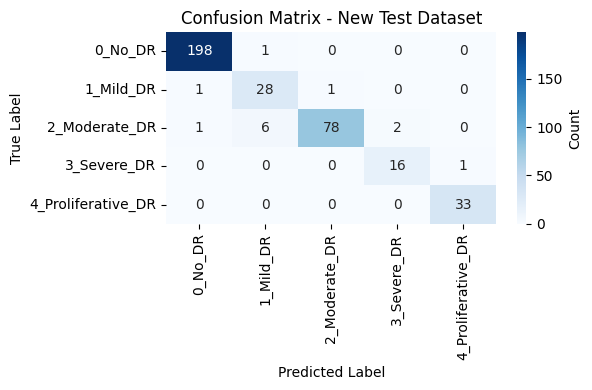


CLASSIFICATION REPORT - NEW TEST DATASET
                    precision    recall  f1-score   support

           0_No_DR       0.99      0.99      0.99       199
         1_Mild_DR       0.80      0.93      0.86        30
     2_Moderate_DR       0.99      0.90      0.94        87
       3_Severe_DR       0.89      0.94      0.91        17
4_Proliferative_DR       0.97      1.00      0.99        33

          accuracy                           0.96       366
         macro avg       0.93      0.95      0.94       366
      weighted avg       0.97      0.96      0.96       366


ACCURACY PER CLASS
0_No_DR: 99.50% (198/199)
1_Mild_DR: 93.33% (28/30)
2_Moderate_DR: 89.66% (78/87)
3_Severe_DR: 94.12% (16/17)
4_Proliferative_DR: 100.00% (33/33)

COHEN'S KAPPA SCORE
Kappa Score: 0.9439


In [14]:
model = tf.keras.models.load_model('inceptionv3.keras')  


img_size = (299, 299)  
batch_size = 32

test_ds = tf.keras.utils.image_dataset_from_directory(
    "test_preprocessed",
    image_size=img_size,
    batch_size=batch_size,
    label_mode="categorical",
    shuffle=False
)


class_names = test_ds.class_names


def preprocess(images, labels):
    images = tf.cast(images / 255.0, tf.float32)
    return images, labels

test_ds = test_ds.map(preprocess).prefetch(tf.data.AUTOTUNE)

y_true = []
y_pred = []


for images, labels in test_ds:
    predictions = model.predict(images, verbose=0)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)


cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - New Test Dataset')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("CLASSIFICATION REPORT - NEW TEST DATASET")
print("="*60)
print(classification_report(y_true, y_pred, target_names=class_names))

print("\n" + "="*60)
print("ACCURACY PER CLASS")
print("="*60)
for i, class_name in enumerate(class_names):
    class_correct = cm[i, i]
    class_total = cm[i].sum()
    class_accuracy = class_correct / class_total if class_total > 0 else 0
    print(f"{class_name}: {class_accuracy*100:.2f}% ({class_correct}/{class_total})")


kappa_score = cohen_kappa_score(y_true, y_pred)


print("\n" + "="*60)
print("COHEN'S KAPPA SCORE")
print("="*60)
print(f"Kappa Score: {kappa_score:.4f}")
print("="*60)

#### Resnet50 Testing

Found 366 files belonging to 5 classes.


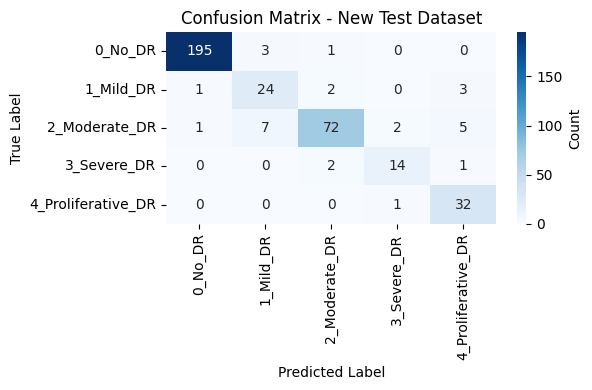


CLASSIFICATION REPORT - NEW TEST DATASET
                    precision    recall  f1-score   support

           0_No_DR       0.99      0.98      0.98       199
         1_Mild_DR       0.71      0.80      0.75        30
     2_Moderate_DR       0.94      0.83      0.88        87
       3_Severe_DR       0.82      0.82      0.82        17
4_Proliferative_DR       0.78      0.97      0.86        33

          accuracy                           0.92       366
         macro avg       0.85      0.88      0.86       366
      weighted avg       0.93      0.92      0.92       366


ACCURACY PER CLASS
0_No_DR: 97.99% (195/199)
1_Mild_DR: 80.00% (24/30)
2_Moderate_DR: 82.76% (72/87)
3_Severe_DR: 82.35% (14/17)
4_Proliferative_DR: 96.97% (32/33)

COHEN'S KAPPA SCORE
Kappa Score: 0.8757


In [17]:
model = tf.keras.models.load_model('resnet50.keras')  


img_size = (224, 224)  
batch_size = 32

test_ds = tf.keras.utils.image_dataset_from_directory(
    "test_preprocessed",
    image_size=img_size,
    batch_size=batch_size,
    label_mode="categorical",
    shuffle=False
)


class_names = test_ds.class_names


def preprocess(images, labels):
    images = tf.keras.applications.resnet50.preprocess_input(images)
    return images, labels

test_ds = test_ds.map(preprocess).prefetch(tf.data.AUTOTUNE)

y_true = []
y_pred = []


for images, labels in test_ds:
    predictions = model.predict(images, verbose=0)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)


cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - New Test Dataset')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("CLASSIFICATION REPORT - NEW TEST DATASET")
print("="*60)
print(classification_report(y_true, y_pred, target_names=class_names))

print("\n" + "="*60)
print("ACCURACY PER CLASS")
print("="*60)
for i, class_name in enumerate(class_names):
    class_correct = cm[i, i]
    class_total = cm[i].sum()
    class_accuracy = class_correct / class_total if class_total > 0 else 0
    print(f"{class_name}: {class_accuracy*100:.2f}% ({class_correct}/{class_total})")


kappa_score = cohen_kappa_score(y_true, y_pred)


print("\n" + "="*60)
print("COHEN'S KAPPA SCORE")
print("="*60)
print(f"Kappa Score: {kappa_score:.4f}")
print("="*60)